<h1>TensorRT와 Tritonserver를 활용한 Inference optimization & Model Deployment</h1>

TensorRT를 활용하여 half precision Inference를 하고, Tritonserver를 이용하여 최적화된 모델을 서버에 배포하여 봅시다. 
By MoNET CY LEE 

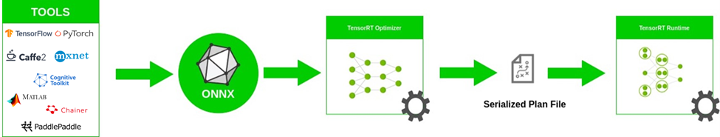
---



## <strong>Quantization</strong>

Reference: [NVIDIA tech 블로그](https://developer.nvidia.com/blog/achieving-fp32-accuracy-for-int8-inference-using-quantization-aware-training-with-tensorrt/)

Reference: [2022 AI developer Meetup](https://github.com/leejinho610/TRT_Triton_HandsOn)


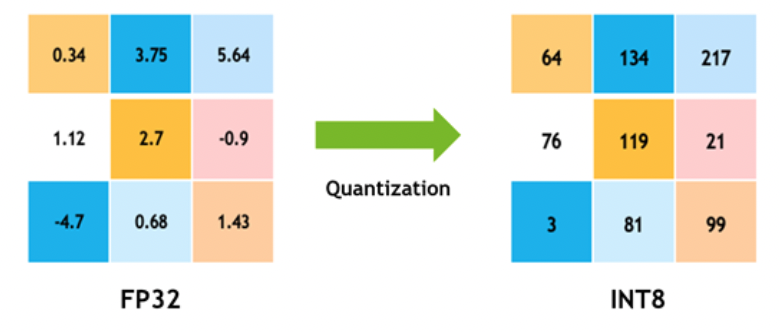


float32는 <strong>[-3.4e38, 3.4e38]</strong> 표현 가능하다. 그중 [-1,1]을 가장 밀도 있게 표현한다. 가장 precision이 높은 구간은 [-1,1]이다. 


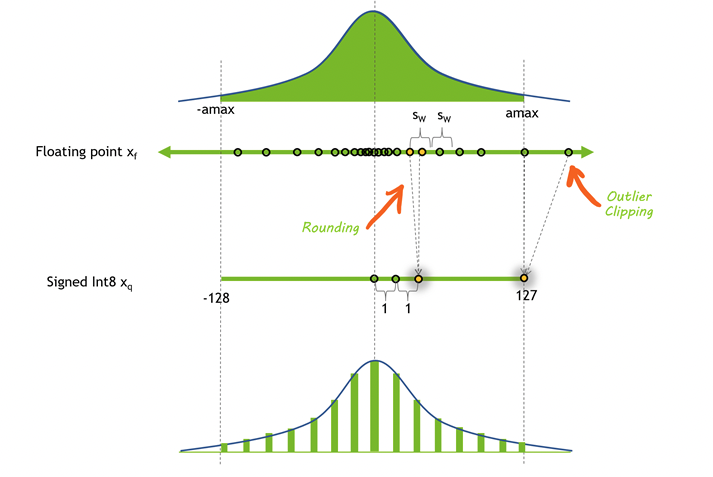


8-bit integer representation을 위해선 이를 256개의 값만으로 표현해야함. 

$x_{q} = Clip(Round(x_{f}/scale))$

scale-factor 는 tensor의 dynamic range를 [-128,128]로 mapping 시켜준다. Round는 정수범위로 반올림 해주고, outer range는 clipping해준다. 

$amax = max(abs(x_{f}))$
$scale = (2 * amax) / 256$

이번 예제에서는 <strong>float16 quantization</strong> 혹은 <strong>half-precision</strong> 까지 진행해보도록 한다.

# Run Jupyter Notebook inside Docker container
*   `docker run --gpus '"device=0"' -it --rm -p 8887:8887 -v $(pwd):/hello nvcr.io/nvidia/tensorrt:22.03-py3` (pull NGC container first)

*   jupyter notebook --ip 0.0.0.0 --port 8887
*   or you can build singularity iamge from `singularity build --sandbox triton docker://nvcr.io/nvidia/tensorrt:22.03-py3`

In [ ]:
import torch
from torch import nn
from torchvision import models


model = models.wide_resnet101_2(pretrained=True).eval().cuda()
script_model = torch.jit.script(model)
script_model.save('model.pt')

In [ ]:
input_names = ["actual_input_1"]
output_names = ["output_1"]
torch.onnx.export(model, torch.randn(1, 3, 224, 224).cuda(), 'model.onnx',
                  input_names=input_names, output_names=output_names,
                  dynamic_axes={'actual_input_1':{0:'batch_size'}, 'output_1': {0:'batch_size'}})

E: Invalid operation docker


In [ ]:
!trtexec \
  --onnx=model.onnx \
  --explicitBatch \
  --optShapes=actual_input_1:16x3x224x224 \
  --maxShapes=actual_input_1:32x3x224x224 \
  --minShapes=actual_input_1:1x3x224x224 \
  --best \
  --saveEngine=model.plan

/bin/bash: docker: command not found


# Run Tritonserver inside Docker container

*   `docker run --gpus='"device=1"' --rm -p8000:8000 -p8001:8001 -p8002:8002 -v $(pwd)/models:/models nvcr.io/nvidia/tritonserver:22.03-py3 tritonserver --model-repository=/models`
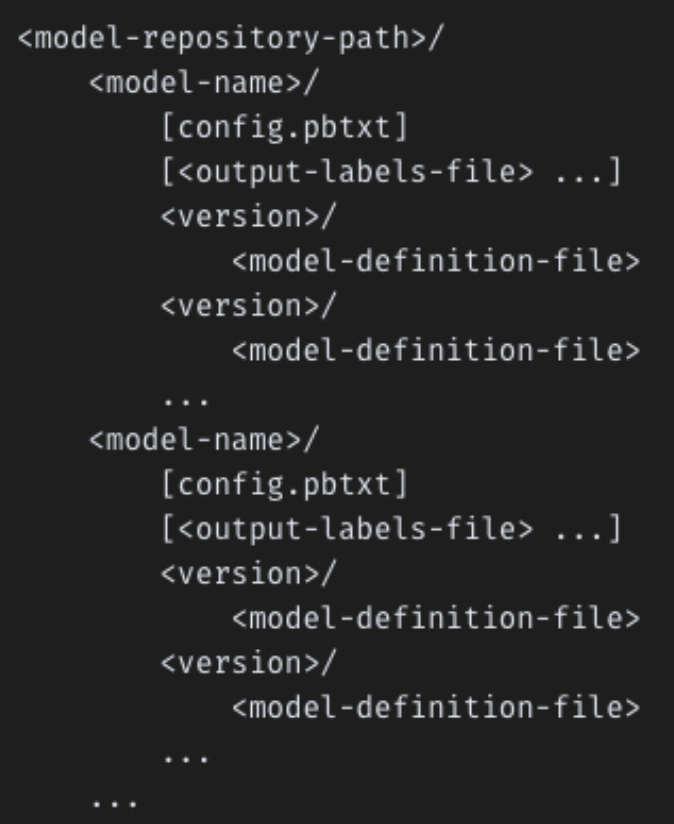

# PTQ and QAT

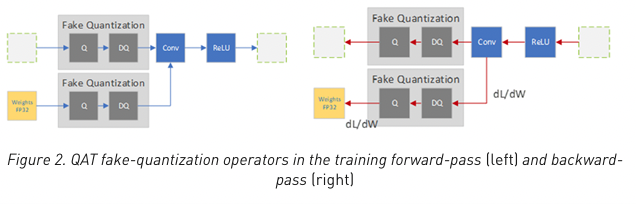